In [1]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
#import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import torchvision
#import albumentations as albu
#from albumentations.pytorch.transforms import ToTensor
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import Sampler
import sys
import torch.optim as optim


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [117]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))
    
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs    
    
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs    
    
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out    
    
unet = UNet().to(device)
x    = torch.randn(1, 3, 572, 572, device=device)
unet(x).shape    

torch.Size([1, 1, 388, 388])

In [118]:
## import unet.py

In [119]:
import unet
unet = unet.UNet().to(device)
x    = torch.randn(1, 3, 320, 320, device=device)
unet(x).shape

ModuleNotFoundError: No module named 'unet'

In [2]:
sys.path.append('/home/msadmin/notebooks/msc8001/src')

In [3]:
images_directory =  "../data/usq/images/"
masks_directory = "../data/usq/masks/"

In [4]:
## PyTorch transforms

In [5]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomAffine(
            degrees=15,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05),
            resample=2,
            fillcolor=0,
        ),
        transforms.ColorJitter(
            brightness=0.15,
            contrast=0.15,
            saturation=0.15,
            hue=0.05
        ),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


In [ ]:
tgt_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomAffine(
            degrees=15,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05),
            resample=2,
            fillcolor=0,
        ),
        transforms.ColorJitter(
            brightness=0.15,
            contrast=0.15,
            saturation=0.15,
            hue=0.05
        ),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [28]:
# Use segmentatoin dataset definition
from SegmentationDataset import SegmentationDataset

MRADataset = SegmentationDataset(
    dir_images="../data/usq/images/",
    dir_masks="../data/usq/masks/",
    transform=transform,
    #    target_transform=
)
#MRADataset.to(device)

In [32]:
## Albumentations Transforms

In [27]:
from albumentations.pytorch import ToTensorV2
transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)    

In [22]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames  = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

In [23]:
# use MRADataset definition
from MRADataset import MRADataset

MRADataset = MRADataset(
    correct_images_filenames,
    images_directory, 
    masks_directory,
    transform=transform,
    #    target_transform=
)
#MRADataset.to(device)

In [29]:
import random
import copy
import albumentations as A
import albumentations.augmentations.functional as F

def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


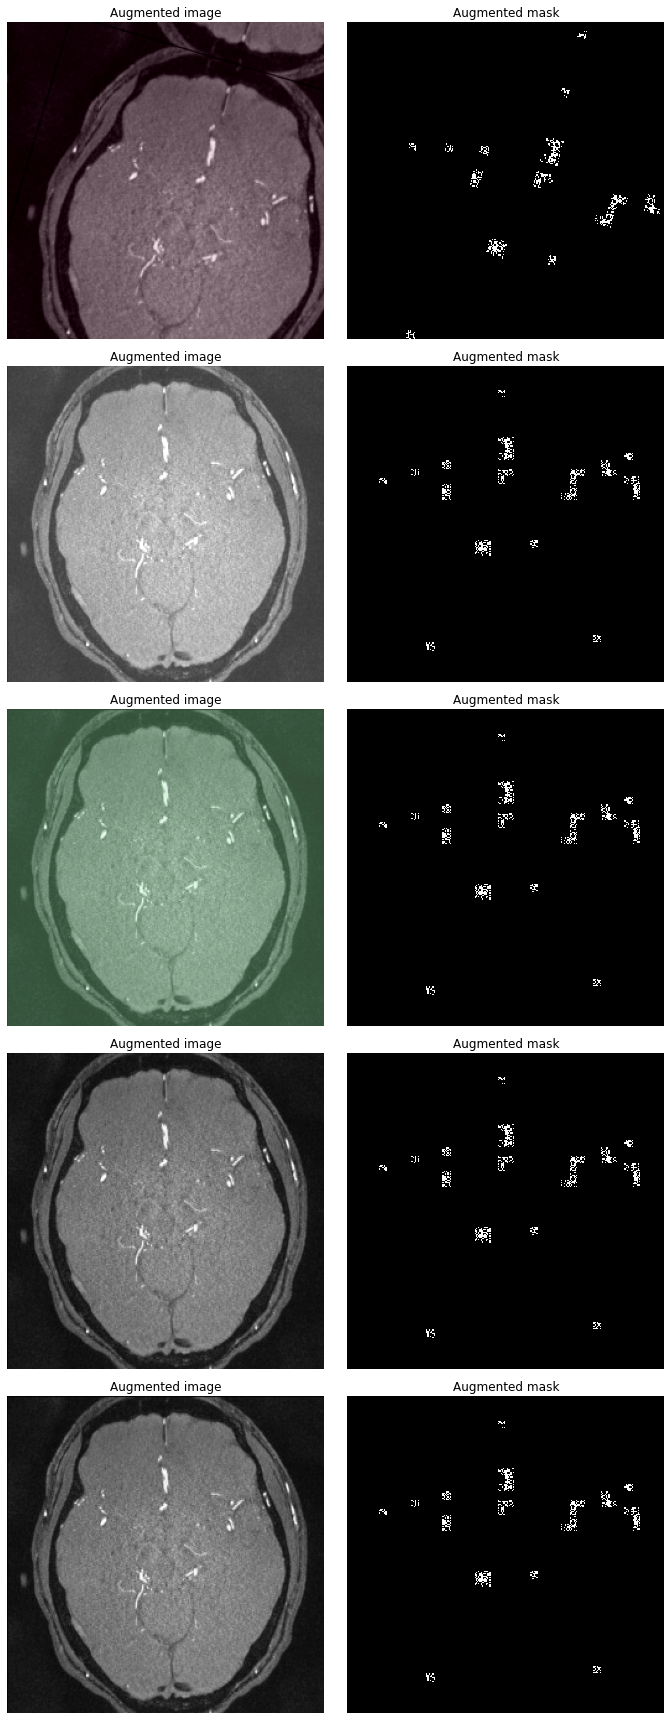

In [30]:
random.seed(42)
visualize_augmentations(MRADataset, idx=55)

torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


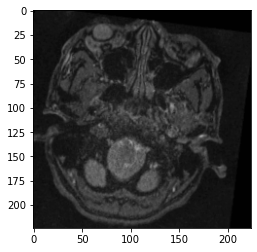

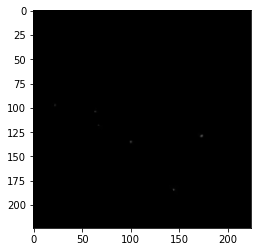

torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


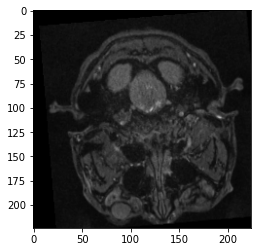

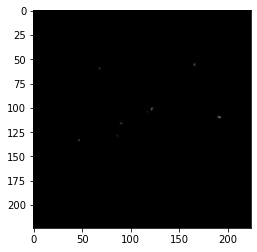

torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


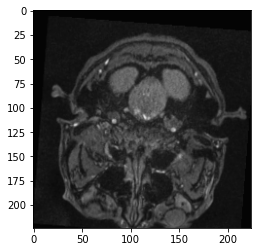

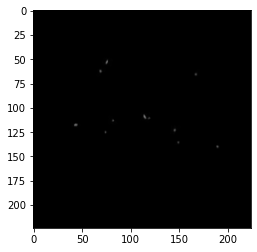

torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


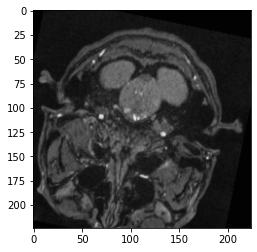

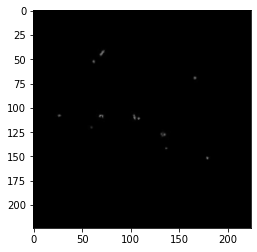

torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


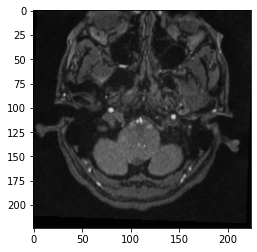

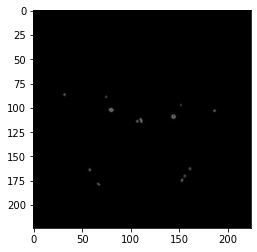

In [29]:
#for i in range(len(dataset)):
for i in range(5):    
    img_, mask_ = MRADataset[i]
    img_ = img_.permute(1, 2, 0)
    mask_ = mask_.permute(1, 2, 0)
    print(img_.size())
    print(mask_.size())
    plt.imshow(img_)
    plt.figure()
    plt.imshow(mask_)
    plt.show()

In [30]:
#TTR is Train Test Ratio
def trainTestSplit(dataset, TTR):
    trainDataset = torch.utils.data.Subset(dataset, range(0, int(TTR * len(dataset))))
    valDataset = torch.utils.data.Subset(dataset, range(int(TTR*len(dataset)), len(dataset)))
    return trainDataset, valDataset
  
batchSize = 16
trainDataset, valDataset = trainTestSplit(MRADataset, 0.9)
trainLoader = DataLoader(trainDataset, batch_size = batchSize, shuffle=True, drop_last=True)
valLoader = DataLoader(valDataset, batch_size = batchSize, shuffle=True, drop_last=True)

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16, 3, 224, 224])


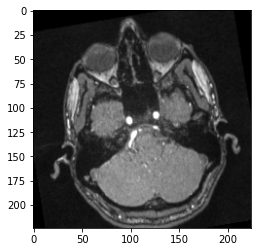

In [31]:
# Display image and label.
train_features, train_labels = next(iter(trainLoader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().permute(1,2,0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
#print(f"Label: {label}")

In [32]:
print('Min intensity value: ',trainDataset[0][1].min().item())
print('Max intensity value: ',trainDataset[0][1].max().item())

Min intensity value:  0.0
Max intensity value:  0.3490196168422699


In [ ]:
def meanIOU(target, predicted):
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    iousum = 0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        intersection = np.logical_and(target_arr, predicted_arr).sum()
        union = np.logical_or(target_arr, predicted_arr).sum()
        if union == 0:
            iou_score = 0
        else :
            iou_score = intersection / union
        iousum +=iou_score
        
    miou = iousum/target.shape[0]
    return miou

In [ ]:
def pixelAcc(target, predicted):    
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    accsum=0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        same = (target_arr == predicted_arr).sum()
        a, b = target_arr.shape
        total = a*b
        accsum += same/total
    
    pixelAccuracy = accsum/target.shape[0]        
    return pixelAccuracy

In [33]:
optimizer = optim.Adam(model.parameters(), lr=0.00005)
loss_fn = nn.BCEWithLogitsLoss ()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

In [47]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [34]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   
        print(f"X: {X.size()}")
        print(f"Y: {y.size()}")     
        # Compute prediction and loss
        pred = model(X)
        print(f"Predict size: {pred.size()}")   
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [36]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainLoader, model, loss_fn, optimizer)
    test_loop(valLoader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
X: torch.Size([16, 3, 224, 224])
Y: torch.Size([16, 3, 224, 224])
Predict size: torch.Size([16, 2, 224, 224])


ValueError: Target size (torch.Size([16, 3, 224, 224])) must be the same as input size (torch.Size([16, 2, 224, 224]))

In [ ]:
from torchinfo import summary
summary(unet)

## Dense UNet

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
#import segmentation_models_pytorch as smp
import torch.nn as nn
from collections import defaultdict
import torchvision
#import albumentations as albu
#from albumentations.pytorch.transforms import ToTensor
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import Sampler
import sys
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
import random

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [4]:
sys.path.insert(0, "..")

In [5]:
from src.dense_unet import DenseUNet

pretrained_encoder_uri = 'https://download.pytorch.org/models/densenet121-a639ec97.pth'
#
# for a local file use
#
# from pathlib import Path
# pretrained_encoder_uri = Path('/path/to/local/model.pth').resolve().as_uri()
#

num_output_classes = 1
model = DenseUNet(num_output_classes, downsample=True, pretrained_encoder_uri=pretrained_encoder_uri)

In [6]:
# model = model.to(device)
# x    = torch.randn(1, 3, 224, 224, device=device)
# model(x).shape

In [7]:
model = model.to(device)
x    = torch.randn(1, 3, 320, 320, device=device)
model(x).shape

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 1, 320, 320])

In [8]:
images_directory =  "../data/usq/mipimages/"
masks_directory = "../data/usq/mipmasks/"

In [8]:
images_directory =  "../data/usq/images/"
masks_directory = "../data/usq/masks/"

In [9]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:1960]
val_images_filenames = correct_images_filenames[1960:-10]
test_images_filenames = images_filenames[-10:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1960 485 10


In [10]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask <= 100] = 0
    mask[mask > 100] = 1.0
    return mask

In [11]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #mask = cv2.imread(os.path.join(masks_directory, image_filename), cv2.IMREAD_UNCHANGED,)
        mask = cv2.imread(os.path.join(masks_directory, image_filename))
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

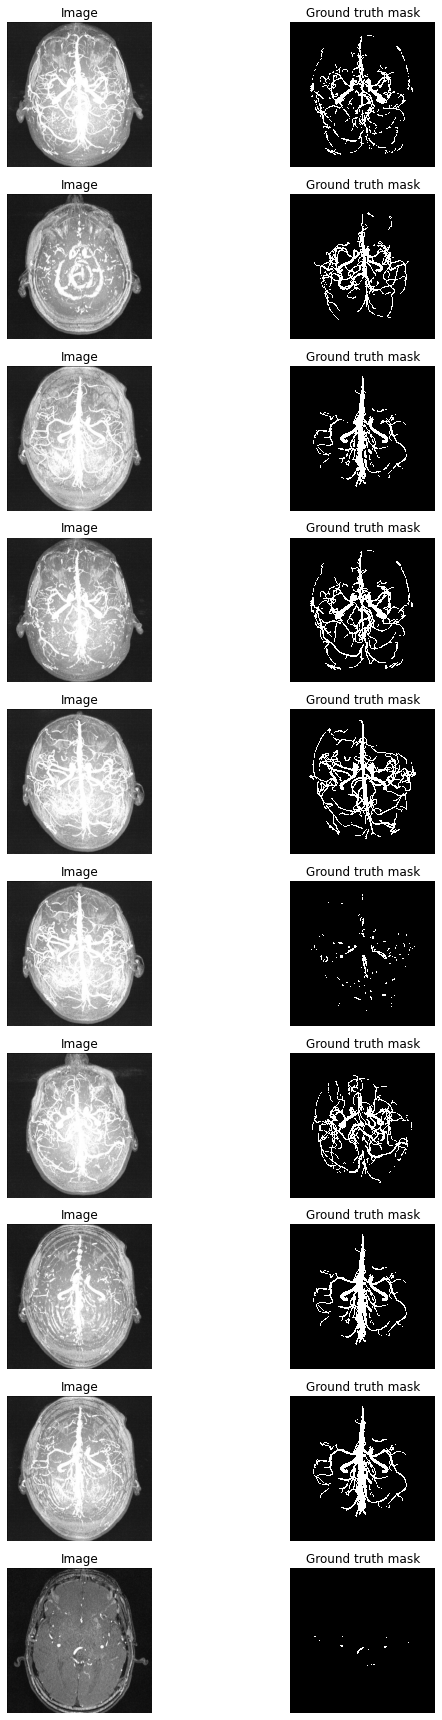

In [12]:
display_image_grid(train_images_filenames[:10], images_directory, masks_directory)

In [13]:
class MRADataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def _preprocess_mask(self, mask):
        mask = mask.astype(np.float32)
        mask[mask <= 100] = 0
        mask[mask > 100] = 1.0
        return mask
    
    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename), cv2.IMREAD_UNCHANGED,
        )
        mask = self._preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        #return image.transpose(2, 0, 1), mask
        img_tensor = torch.from_numpy(image)
        img_tensor = img_tensor.permute(2, 0, 1)
        msk_tensor = torch.from_numpy(mask)
        #print(f'mask shape: {msk_tensor.shape}')#msk_tensor = msk_tensor.permute(2, 0, 1)
        return img_tensor, msk_tensor

In [14]:
train_dataset = MRADataset(train_images_filenames, images_directory, masks_directory)#, transform=train_transform,)
val_dataset = MRADataset(val_images_filenames, images_directory, masks_directory)#, transform=val_transform,)

In [15]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [16]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        # KB 09/09
        #print(f'images: {images.shape}, target: {target.shape}')
        ##target = target.unsqueeze(-1) # -1 stands for last here equivalent to 1
        #print(f'target: {target.shape}')
        ##target = target.permute(0, 3, 1, 2)
        images = images.float()
        output = model(images).squeeze(1)
        #print(f'output: {output.shape}, target: {target.shape}')
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [17]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            #target = target.unsqueeze(-1) # -1 stands for last here equivalent to 1
            # KB 12/09
            images = images.float()
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [18]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay = 0.001)
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model

In [19]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

In [24]:
params = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.01,
    "batch_size": 8,
    "num_workers": 4,
    "epochs": 5,
}

In [25]:
#import ternausnet.models

In [26]:
def create_model(params):
    model = getattr(ternausnet.models, params["model"])(pretrained=True)
    model = model.to(params["device"])
    return model

In [27]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [28]:
#model = create_model(params)
#model(inputs.permute(0, 3, 1, 2))
#model = train_and_validate(model, train_dataset.permute(0, 3, 1, 2), val_dataset.permute(0, 3, 1, 2), params)
model = train_and_validate(model, train_dataset, val_dataset, params)

Epoch: 2. Train.      Loss: 1.238:  47%|████▋     | 116/245 [00:30<00:34,  3.78it/s]


KeyboardInterrupt: 

In [29]:
encoder = nn.Sequential(*list(models.densenet121().children())[0])
unet = DynamicUnet(encoder, n_classes=1, img_size=(320, 320), blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False)
print(unet(torch.rand(1,3,320,320)).shape)


NameError: name 'models' is not defined